In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tqdm.auto import tqdm
from rl_analysis.plotting import setup_plotting_env, geno_palette, savefig, clean_ticks
from rl_analysis.util import rle
import pandas as pd

import os
import seaborn as sns
import numpy as np

# Load in raw data and normalize

In [3]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [4]:
raw_dirs = analysis_config["raw_data"]
proc_dirs = analysis_config["intermediate_results"]
closed_loop_cfg = analysis_config["closed_loop_behavior"]
figure_cfg = analysis_config["figures"]

In [5]:
learner_dct = toml.load(
    os.path.join(proc_dirs["closed_loop_behavior"], "closed_loop_learners.toml")
)
learners = []
for k, v in learner_dct.items():
    learners += v["learners"]

In [6]:
feedback_df = pd.read_parquet(
    os.path.join(raw_dirs["closed_loop_behavior"], "closed_loop_behavior.parquet"),
    filters=[
        ("experiment_type", "in", ["reinforcement"]),
        ("area", "in", ["snc (axon)", "ctrl"]),
    ],
)

feedback_df = feedback_df.loc[
    (feedback_df["area"].isin(["snc (axon)", "ctrl"]))
    & (feedback_df["opsin"].isin(["chr2", "ctrl"]))
].copy()

feedback_df.rename(
    columns={"predicted_syllable_number": "syllable_number"}, inplace=True
)

In [7]:
# get feedback status...

In [8]:
rle_df = feedback_df.groupby("uniq_id")["predicted_syllable"].apply(rle)
rle_df.index = rle_df.index.droplevel(0)

In [9]:
rle_df = feedback_df.loc[rle_df.index]

In [10]:
all_duration = rle_df.groupby("uniq_id")["timestamp"].shift(-1) - rle_df["timestamp"]
rle_df["duration"] = (
    rle_df.groupby("uniq_id")["timestamp"].shift(-1) - rle_df["timestamp"]
)

In [11]:
feedback_df["is_stim"] = (feedback_df["session_number"].isin([1, 2])) & (
    feedback_df["feedback_status"] == 1
)
feedback_df["is_catch"] = (feedback_df["session_number"].isin([1, 2])) & (
    feedback_df["feedback_status"] == 0
)

In [12]:
fbacks = feedback_df.groupby(["uniq_id", "syllable_number"])["is_stim"].any()
catches = feedback_df.groupby(["uniq_id", "syllable_number"])["is_catch"].any()

In [13]:
try:
    rle_df = rle_df.set_index(["uniq_id", "syllable_number"]).sort_index()
except KeyError:
    pass

In [14]:
rle_df["is_feedback"] = fbacks
rle_df["is_catch"] = catches

In [15]:
rle_df = rle_df.reset_index()

In [16]:
baseline_feedbacks = rle_df.loc[rle_df["session_number"] <= 0, "is_feedback"]
baseline_fback_idx = baseline_feedbacks.loc[baseline_feedbacks].index.tolist()

In [17]:
catch_prob = 0.25

In [18]:
nchoose = np.round(catch_prob * len(baseline_fback_idx)).astype("int")
rle_df.loc[np.random.choice(baseline_fback_idx, nchoose), "is_catch"] = True
rle_df.loc[np.random.choice(baseline_fback_idx, nchoose), "is_feedback"] = False

In [19]:
rle_df["status"] = np.nan
rle_df.loc[rle_df["is_feedback"], "status"] = "feedback"
rle_df.loc[rle_df["is_catch"], "status"] = "catch"
rle_df["status"] = rle_df["status"].fillna("n/a")

In [20]:
rle_df["session_type"] = "baseline"
rle_df.loc[rle_df["session_number"].isin([1, 2]), "session_type"] = "stim"

In [21]:
try:
    rle_df = rle_df.set_index(["uniq_id", "syllable_number"]).sort_index()
except KeyError:
    pass

In [22]:
use_scalars = [
    "velocity_2d_mm",
    "acceleration_2d_mm",
    "velocity_angle",
    "velocity_height",
]

In [23]:
agg_scalars = feedback_df.groupby(["uniq_id", "syllable_number"])[use_scalars].mean()
rle_df = rle_df.drop(agg_scalars.columns, axis=1, errors="ignore")
rle_df = rle_df.join(agg_scalars)

z_mu = rle_df.groupby(["session_type", "mouse_id"])[use_scalars].mean().loc["baseline"]
z_sig = rle_df.groupby(["session_type", "mouse_id"])[use_scalars].std().loc["baseline"]
rle_df = rle_df.set_index(["mouse_id"])
rle_df[use_scalars] = (rle_df[use_scalars] - z_mu.loc[rle_df.index]) / z_sig.loc[
    rle_df.index
]

In [24]:
rle_df = rle_df.reset_index()

In [25]:
syllable_norm_scalars = [f"{_}_syll_z" for _ in use_scalars]

In [26]:
z_mu = (
    rle_df.groupby(["session_type", "mouse_id", "predicted_syllable"])[use_scalars]
    .mean()
    .loc["baseline"]
)
z_sig = (
    rle_df.groupby(["session_type", "mouse_id", "predicted_syllable"])[use_scalars]
    .std()
    .loc["baseline"]
)
rle_df = rle_df.set_index(["mouse_id", "predicted_syllable"])

z_mu = z_mu.reindex(rle_df.index)
z_sig = z_sig.reindex(rle_df.index)

In [27]:
for _new_scalar, _scalar in tqdm(zip(syllable_norm_scalars, use_scalars)):
    rle_df[_new_scalar] = (rle_df[_scalar] - z_mu[_scalar]) / z_sig[_scalar]

0it [00:00, ?it/s]

In [28]:
rle_df = rle_df.reset_index()

In [29]:
rle_df["learner"] = rle_df["mouse_id"].isin(learners)
rle_df["learner"] = rle_df["learner"].map({True: "yes", False: "no"})
rle_df.loc[rle_df["area"] == "ctrl", "learner"] = "ctrl"

In [30]:
# fold in scalars...

In [31]:
target_rle_df = rle_df.loc[
    rle_df["predicted_syllable"] == rle_df["target_syllable"]
].copy()

In [32]:
target_rle_df["duration_z"] = target_rle_df.groupby(["mouse_id", "predicted_syllable"])[
    "duration"
].transform(lambda x: (x - x.mean()) / x.std())

In [33]:
target_rle_df.loc[target_rle_df["session_number"] <= 0, "session_type"] = "baseline"
target_rle_df["session_type"].fillna("stim", inplace=True)

In [34]:
target_rle_df["log(duration)"] = np.log(target_rle_df["duration"])

/home/markowitzmeister_gmail_com/miniconda3/envs/spont-da/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [35]:
dur_mu = target_rle_df.groupby(
    ["mouse_id", "area", "learner", "predicted_syllable", "session_type"]
)["duration"].mean()
dur_sig = target_rle_df.groupby(
    ["mouse_id", "area", "learner", "predicted_syllable", "session_type"]
)["duration"].std()

diff_z = (
    dur_mu.xs("stim", level="session_type")
    - dur_mu.xs("baseline", level="session_type")
) / dur_mu.xs("baseline", level="session_type")

In [36]:
from scipy.stats import mannwhitneyu, kstest

In [37]:
dur_means = target_rle_df.groupby(
    ["learner", "session_number", "mouse_id", "target_syllable", "status"]
)["duration"].mean()

In [38]:
setup_plotting_env()
sns.set_context("paper")

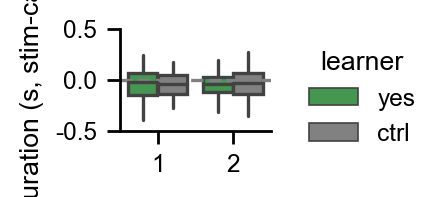

In [39]:
g = sns.catplot(
    data=(
        (
            dur_means.xs("feedback", level="status")
            - dur_means.xs("catch", level="status")
        ).dropna()
    )
    .groupby(["learner", "target_syllable", "mouse_id", "session_number"])
    .mean()
    .reset_index(),
    x="session_number",
    hue="learner",
    hue_order=["yes", "ctrl"],
    palette=[geno_palette.snc, geno_palette.ctrl],
    y="duration",
    kind="box",
    height=1.25,
    aspect=1.25,
    showfliers=False,
    showcaps=False,
)
clean_ticks(g.axes.flat[0], "y", precision=1)
g.set(ylim=(-0.5, 0.5))
g.refline(y=0)
g.set_axis_labels("", "Duration (s, stim-catch)")
savefig(
    g.fig,
    os.path.join(figure_cfg["store_dir"], "target_duration_catch-stim"),
    bbox_inches="tight",
)

In [40]:
scalar_means = target_rle_df.groupby(
    ["learner", "session_number", "mouse_id", "target_syllable", "status"]
)[use_scalars + syllable_norm_scalars].mean()

In [41]:
scalar_diff = (
    scalar_means.xs("feedback", level="status")
    - scalar_means.xs("catch", level="status")
).dropna()
scalar_diff = scalar_diff.melt(ignore_index=False)

In [42]:
setup_plotting_env()

In [43]:
aliases = {
    "velocity_2d_mm": "vel.",
    "acceleration_2d_mm": "acc.",
    "velocity_angle": "vel. ang.",
    "velocity_height": "vel. z",
    "_syll_z": "",
}

In [44]:
compare_groups = ["yes", "ctrl"]
compare_variables = syllable_norm_scalars

In [45]:
use_data = (
    scalar_diff.groupby(
        ["learner", "mouse_id", "session_number", "target_syllable", "variable"]
    )
    .mean()
    .dropna()
)

In [46]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

In [47]:
use_test = mannwhitneyu

In [48]:
stats = []

In [49]:
import itertools

In [50]:
for _variable in compare_variables:
    for (_group1, _group2) in itertools.combinations(compare_groups, 2):
        for _sess in [1, 2]:
            dat1 = use_data.xs(
                (_group1, _variable, _sess),
                level=("learner", "variable", "session_number"),
            )
            dat2 = use_data.xs(
                (_group2, _variable, _sess),
                level=("learner", "variable", "session_number"),
            )
            comparison = f"{_group1}-{_group2}-{_sess}"
            stat, p = use_test(dat1, dat2)
            dct = {}
            dct["type"] = "catch-stim withinsyllable"
            dct["comparison"] = comparison
            dct["variable"] = _variable
            dct["stat"] = stat[0]
            dct["p"] = p[0]
            dct["n1"] = len(dat1)
            dct["n2"] = len(dat2)
            dct["f"] = stat[0] / (len(dat1) * len(dat2))
            dct["n_definition"] = "mouse-session-target triplets"
            stats.append(dct)

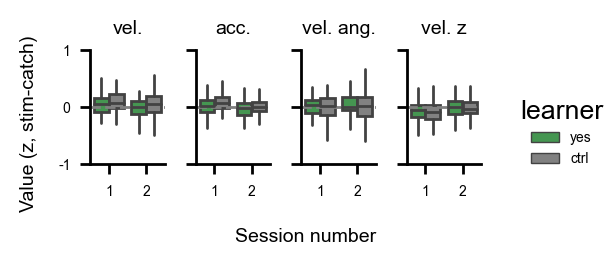

In [51]:
g = sns.catplot(
    data=use_data.reset_index(),
    x="session_number",
    y="value",
    col="variable",
    col_wrap=4,
    col_order=syllable_norm_scalars,
    height=1.25,
    aspect=0.5,
    hue="learner",
    hue_order=["yes", "ctrl"],
    palette=[geno_palette.snc, geno_palette.ctrl],
    kind="box",
    showfliers=False,
    showcaps=False,
    sharex=True,
    sharey=True,
)
clean_ticks(g.axes.flat[0], "y", precision=0, dtype=int)
g.refline(y=0)
g.set(ylim=(-1, 1))
g.set_titles(row_template="{row_name}", col_template="{col_name}")
for _ax in g.axes.flat:
    title = _ax.get_title()
    for k, v in aliases.items():
        title = title.replace(k, v)
    _ax.set_title(title)
g.set_axis_labels("", "")
g.fig.supxlabel("Session number", fontsize=7)
g.fig.supylabel("Value (z, stim-catch)", fontsize=7)
savefig(
    g.fig,
    os.path.join(figure_cfg["store_dir"], "target_scalars_catch-stim_withinsyll-norm"),
    bbox_inches="tight",
)

In [52]:
use_data = (
    (
        target_rle_df.groupby(
            ["learner", "session_number", "mouse_id", "target_syllable"]
        )[use_scalars + syllable_norm_scalars]
        .mean()
        .melt(ignore_index=False)
    )
    .set_index("variable", append=True)
    .dropna()
)

In [53]:
for _variable in compare_variables:
    for (_group1, _group2) in itertools.combinations(compare_groups, 2):
        for _sess in [1, 2]:
            dat1 = use_data.xs(
                (_group1, _variable, _sess),
                level=("learner", "variable", "session_number"),
            )
            dat2 = use_data.xs(
                (_group2, _variable, _sess),
                level=("learner", "variable", "session_number"),
            )
            comparison = f"{_group1}-{_group2}-{_sess}"
            stat, p = use_test(dat1, dat2)
            dct = {}
            dct["type"] = "target scalars all withinsyllable"
            dct["variable"] = _variable
            dct["comparison"] = comparison
            dct["stat"] = stat[0]
            dct["p"] = p[0]
            dct["n1"] = len(dat1)
            dct["n2"] = len(dat2)
            dct["f"] = stat[0] / (len(dat1) * len(dat2))
            dct["n_definition"] = "mouse-session-target triplets"
            stats.append(dct)

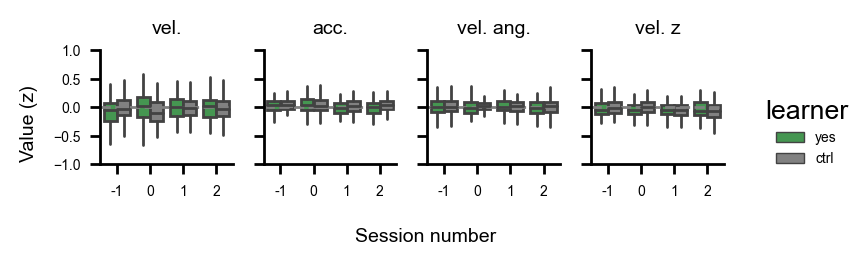

In [54]:
g = sns.catplot(
    data=use_data.reset_index()
    .groupby(["learner", "mouse_id", "session_number", "target_syllable", "variable"])
    .mean()
    .reset_index(),
    x="session_number",
    order=[-1, 0, 1, 2],
    y="value",
    col="variable",
    col_order=syllable_norm_scalars,
    col_wrap=4,
    height=1.25,
    aspect=0.75,
    hue="learner",
    hue_order=["yes", "ctrl"],
    palette=[geno_palette.snc, geno_palette.ctrl],
    kind="box",
    showfliers=False,
    showcaps=False,
    sharex=True,
    sharey=True,
)
g.refline(y=0)
g.set(ylim=(-1, 1))
g.set_titles(row_template="{row_name}", col_template="{col_name}")
for _ax in g.axes.flat:
    title = _ax.get_title()
    for k, v in aliases.items():
        title = title.replace(k, v)
    _ax.set_title(title)
g.set_axis_labels("", "")
g.fig.supxlabel("Session number", fontsize=7)
g.fig.supylabel("Value (z)", fontsize=7)
savefig(
    g.fig,
    os.path.join(figure_cfg["store_dir"], "target_scalars_all_withinsyll-norm"),
    bbox_inches="tight",
)

In [55]:
use_data = (
    (
        rle_df.groupby(["learner", "mouse_id", "target_syllable", "session_number"])[
            use_scalars + syllable_norm_scalars
        ]
        .mean()
        .melt(ignore_index=False)
    )
    .set_index("variable", append=True)
    .dropna()
)

In [56]:
for _variable in compare_variables:
    for (_group1, _group2) in itertools.combinations(compare_groups, 2):
        for _sess in [1, 2]:
            dat1 = use_data.xs(
                (_group1, _variable, _sess),
                level=("learner", "variable", "session_number"),
            )
            dat2 = use_data.xs(
                (_group2, _variable, _sess),
                level=("learner", "variable", "session_number"),
            )
            comparison = f"{_group1}-{_group2}-{_sess}"
            stat, p = use_test(dat1, dat2)
            dct = {}
            dct["type"] = "global scalars"
            dct["variable"] = _variable
            dct["comparison"] = comparison
            dct["stat"] = stat[0]
            dct["p"] = p[0]
            dct["n1"] = len(dat1)
            dct["n2"] = len(dat2)
            dct["f"] = stat[0] / (len(dat1) * len(dat2))
            dct["n_definition"] = "mouse-session-target triplets"
            stats.append(dct)

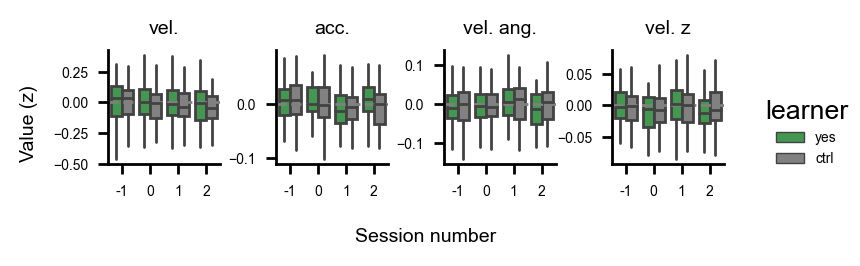

In [57]:
g = sns.catplot(
    data=use_data.reset_index()
    .groupby(["learner", "mouse_id", "session_number", "target_syllable", "variable"])
    .mean()
    .reset_index(),
    x="session_number",
    order=[-1, 0, 1, 2],
    y="value",
    col="variable",
    col_wrap=4,
    col_order=syllable_norm_scalars,
    height=1.25,
    aspect=0.75,
    hue="learner",
    hue_order=["yes", "ctrl"],
    palette=[geno_palette.snc, geno_palette.ctrl],
    kind="box",
    showfliers=False,
    showcaps=False,
    sharex=True,
    sharey=False,
)
g.refline(y=0)
g.set_titles(row_template="{row_name}", col_template="{col_name}")
for _ax in g.axes.flat:
    title = _ax.get_title()
    for k, v in aliases.items():
        title = title.replace(k, v)
    _ax.set_title(title)
g.set_axis_labels("", "")
g.fig.supxlabel("Session number", fontsize=7)
g.fig.supylabel("Value (z)", fontsize=7)
g.fig.subplots_adjust(wspace=0.5)
savefig(
    g.fig,
    os.path.join(figure_cfg["store_dir"], "global_scalars_average"),
    bbox_inches="tight",
)

In [58]:
_tmp = (
    dur_means.xs("feedback", level="status")
    - dur_means.xs("catch", level="status")
    .groupby(
        ["learner", "target_syllable", "mouse_id", "session_number"], observed=True
    )
    .mean()
).dropna()

In [59]:
for (_group1, _group2) in itertools.combinations(compare_groups, 2):
    for _sess in [1, 2]:
        dat1 = _tmp.xs((_group1, _sess), level=("learner", "session_number"))
        dat2 = _tmp.xs((_group2, _sess), level=("learner", "session_number"))
        comparison = f"{_group1}-{_group2}-{_sess}"
        stat, p = use_test(dat1, dat2)
        dct = {}
        dct["type"] = "within syllable duration"
        dct["variable"] = "duration"
        dct["comparison"] = comparison
        dct["stat"] = stat
        dct["p"] = p
        dct["n1"] = len(dat1)
        dct["n2"] = len(dat2)
        dct["f"] = stat / (len(dat1) * len(dat2))
        dct["n_definition"] = "mouse-session-target triplets"
        stats.append(dct)

In [60]:
pval_df = pd.DataFrame(stats)

In [61]:
pval_df["p"] = pval_df.groupby("type")["p"].transform(
    lambda x: multipletests(x, method="holm")[1]
)

In [62]:
import json

In [63]:
with open(
    os.path.join(proc_dirs["closed_loop_behavior"], "stats_duration_and_scalars.toml"),
    "w",
) as f:
    toml.dump(json.loads(pval_df.to_json()), f)